In [27]:
import numpy as np
import os
import sys
from math import log2
import time
from collections import defaultdict
import matplotlib.pyplot as plt

In [28]:
#===========================================#
#to use for testing, amend path to txt file
#===========================================#
sys.path.append(".")
clean_file = open("wifi_db/clean_dataset.txt", 'r')
noisy_file = open("wifi_db/noisy_dataset.txt", 'r')
clean_data = np.loadtxt(clean_file) 
noisy_data = np.loadtxt(noisy_file)

In [29]:
def entropy(data): # input is a multi dimensonal numpy array 
    num_entries = len(data) # total number of instances in the dataset
    outcomes = defaultdict(int) # dict to hold count of each label in dataset
    entropy = 0 # initial entropy value
    for row in data:
        key = row[-1] # label is last value of each instance
        outcomes[key] += 1 # increment the count of the label 

    for key in outcomes:
        outcomes[key] /= num_entries # compute the probability of each label 
        prob_label = outcomes[key] 
        entropy -= (prob_label*log2(prob_label)) # computing the entropy value

    return entropy

In [30]:
def InfoGain(All, Left, Right):
    
    H_SAll=entropy(All) #entropy of parent datset
    Total=len(All)
    Remainder=((len(Left)/Total)*entropy(Left))+((len(Right)/Total)*entropy(Right)) #weighted entropies of left and right datasets
    Gains=H_SAll-Remainder
    
    return Gains

In [31]:

def FIND_SPLIT(dataset):
    emitter = 0
    value = 0
    max_info_gain = 0
    right = []
    left = []
    for x in range(len(dataset[0])-1): #first 7 entries, exclude room
        
        ds = np.array(sorted(dataset, key = lambda y: y[x], reverse=True)) #sort n dimensional array by emitter
        
        for r in range(len(ds)): #iterate over every value for each emitter
            
            split_point = ds[r][x] #current point to check
            if(r!=len(ds)-1 and ds[r+1][x] == split_point): #check for repeated values, use last instance of value as split point
                continue
            info_gain = InfoGain(ds, ds[:r+1],ds[r+1:]) #calculte information gain for current point
            
            if(info_gain > max_info_gain): #if information gain is higher, update the best split point and emitter
                left = ds[:r+1]
                right = ds[r+1:]
                emitter = x
                value = split_point
                max_info_gain = info_gain
            
            
        
    return emitter, value, left, right

In [32]:
def tree_learning(training_data, depth):
    
    if(entropy(training_data) == 0 and len(training_data != 0)): #if all room labels are the same, return leaf which contains room number
        count = len(training_data) #counting the number of entries in the dataset where the room labels are all the same (used later for pruning purposes)
        label = training_data[0][-1]
        leaf = {'emitter':-1, 'value':-1, 'room': label, 'right':-1, 'left':-1, 'count': count, 'leaf': True}
        return leaf, depth
    
    else: 
        em, val, ldata, rdata = FIND_SPLIT(training_data) #split data to get the child datasets and split point
        root = {'emitter': em, 'value': val, 'room': -1, 'right':-1, 'left':-1, 'count': -1, 'leaf': False} #create non leaf node
        root['left'], l_depth = tree_learning(ldata, depth+1) #recursively call tree learning to generate rest of tree, increasing depth
        root['right'], r_depth = tree_learning(rdata, depth+1)
        return root, max(l_depth, r_depth) #return root of tree and depth

In [33]:
def return_result(row, root):
    
    if(root['room']!= -1): #check for leaf node, return room
        return root['room']
    else:
        if(row[root['emitter']]>=root['value']): #traverse tree to find leaf node
            return return_result(row, root['left'])
        else:
            return return_result(row, root['right'])

In [34]:
def confusion_matrix(results_table): 
    
    cm = np.zeros((4,4)) #empty confusion matrix
    
    for i in range (1,5):
        for pair in results_table: #pair[0] is actual value, pair[1] is predicted value by decision tree
            if(i == pair[0] and pair[0] == pair[1]): #count correct predictions and update confusion matrix
                    cm[i-1][i-1]+=1
            if(i == pair[0] and pair[1] != i):
                    cm[i-1][int(pair[1])-1]+=1
    return cm

In [35]:
def accuracy(cm):
    if(np.sum(cm) == 0):
        return 0
    return np.trace(cm)/np.sum(cm) #returns accuracy from confusion matrix

In [36]:
#===========================================#
#function returns BOTH confusion matrix and accuracy, different from specification which only required us to return accuracy
#===========================================#

def evaluate(test, root): 
    
    results_table = np.empty((len(test),2))
    
    for i in range(len(test)): #iterate over test data and generate prediction
        prediction = return_result(test[i], root)
        results_table[i] = [test[i][-1],prediction] #keep track of actual outcome vs predicted outcome
        
    cm = confusion_matrix(results_table) #generate confusion matrix from results table
    tree_accuracy = accuracy(cm) #calculate accuracy from confusion matrix
    
    return cm, tree_accuracy 

In [37]:
#===========================================#
#cross validation WITHOUT pruning
#===========================================#

def cross_validation(dataset):

    np.random.shuffle(dataset) #shuffles dataset

    fold_size = int(len(dataset)/10) 
    running_cm = np.zeros((4,4)) #generate empty confusion matrix
    
    for i in range(10):
        
        #cycling test and training data for cross valdiation
        test = dataset[0+fold_size*i:fold_size*(i+1)] 
        training = np.vstack((dataset[0:0+fold_size*i],dataset[fold_size*(i+1):])) 
        
        root, depth = tree_learning(training, 0) #generate tree for each cycled training dataset
        
        confusion_matrix, tree_accuracy = evaluate(test, root) #generate confusion matrix for current tree   
        running_cm += confusion_matrix #keep track of confusion matrices to calculate average
            
    avg_cm = running_cm/10 #calculate average confusion matrix
    
    return avg_cm #return average confusion matrix
    
    
    

In [38]:
def precision(cm): 
    class_precisions = np.empty(4)
    cols = cm.sum(axis=0) 
    
    for i in range(len(cm)):
        class_precisions[i] = (cm[i][i]/cols[i]) #calculate precision for each class
    
    return class_precisions

In [39]:
def recall(cm):
    class_recalls = np.empty(4)
    rows = cm.sum(axis=1)
   
    for i in range(len(cm)):
        class_recalls[i] = (cm[i][i]/rows[i]) #calculate recall for each class
    
    return class_recalls

In [40]:
def f1(recall, precision):
    class_f1s = np.empty(4)
    for i in range(len(recall)):
        class_f1s[i] = ((2*recall[i]*precision[i])/(recall[i]+precision[i])) #calculate f1 measure for each class using precision and recall values
    
    return class_f1s

In [41]:
def prune(root, validation_set, start): 
        
        
    if ((root['left']['emitter'] == -1) and (root['right']['emitter'] == -1)): #if both children leaf nodes
        
        old = [root['emitter'], root['value'], root['room'], root['right'], root['left'], root['count']] #store all parent and children before pruning

        cm, old_accuracy = evaluate(validation_set, start) #obtain accuracy of tree before prune
        
        
        if(root['left']['count'] > root['right']['count']): #choose majority class label using count value
            root['room'] = root['left']['room']
            root['count'] = root['left']['count']
        else:
            root['room'] = root['right']['room']
            root['count'] = root['right']['count']

        #make parent node into single leaf node
        root['left'] = -1 
        root['right'] = -1
        root['emitter'] = -1
        root['value'] = -1
        root['leaf'] = True
        
        
        cm, new_accuracy = evaluate(validation_set, start) #obtain accuracy of tree after pruning
        
        if new_accuracy < old_accuracy: #if pre-pruned accuracy was better, undo prune
            root['emitter'] = old[0]
            root['value'] = old[1]
            root['room'] = old[2]
            root['right'] = old[3]
            root['left'] = old[4]
            root['count'] = old[5]
        
        return start
            
    else:
        
        #traverse tree to find prunable nodes
        if(root['left']['emitter'] != -1): 
            start = prune(root['left'], validation_set, start)

        if(root['right']['emitter'] != -1):
            start = prune(root['right'], validation_set, start)
            
    return start

In [42]:
#===========================================#
#cross validation WITH pruning
#===========================================#

def cross_validation_prune(dataset):

    np.random.shuffle(dataset) #shuffle dataset
    fold_size = int(len(dataset)/10)
    
    #initialise confusion matrices for pre and post pruned trees
    running_cm = np.zeros((4,4))
    running_cm_pr = np.zeros((4,4))
    worse = False
    
    for i in range(10):
        
        #cycle test, training and validation sets
        test = dataset[fold_size*i:fold_size*(i+1)]
        validation = dataset[fold_size*(i+1)+1:fold_size*(i+2)+1]
        training = np.vstack((dataset[0:fold_size*i],dataset[fold_size*(i+2)+1:]))
        
        #generate decision tree
        root, depth = tree_learning(training, 0)
                
        confusion_matrix, tree_accuracy = evaluate(test, root) #generate confusion matrix for current tree   
        running_cm += confusion_matrix #keep track of confusion matrices to calculate average
        old_acc = tree_accuracy
        while(True): #keep pruning until accuracy does not improve
            pruned_tree = prune(root, validation, root) #generate pruned tree
            x, cur_acc = evaluate(validation, root)
            if(cur_acc <= old_acc):
                break
            old_acc = cur_acc
            
        #print('Depth after:', maxheight(pruned_tree))
        
        cm_prune, pr_acc = evaluate(test, pruned_tree) #generate confusion matrix for current pruned tree 
        running_cm_pr += cm_prune #keep track of confusion matrices to calculate average for pruned tree
        
        #print(depth, " vs ", maxheight(pruned_tree))
        
#       print(tree_accuracy, " vs ", pr_acc)
        
    
    avg_cm = running_cm/10
    avg_cm_pr = running_cm_pr/10
    
#   print("Before prune accuracy:", accuracy(avg_cm))
#   print("After prune accuracy:", accuracy(avg_cm_pr))
    
    return avg_cm, avg_cm_pr
    

In [43]:
#===========================================#
#nested cross validation WITH pruning
#===========================================#

def nested_cross_validation_prune(dataset):

    np.random.shuffle(dataset) #shuffle dataset
    fold_size = int(len(dataset)/10)
    
    #initialise confusion matrices for pre and post pruned trees
    running_cm = np.zeros((4,4))
    running_cm_pr = np.zeros((4,4))
    
    for j in range(10):
    
        test = dataset[fold_size*j:fold_size*(j+1)]
        traning_validation_dataset = np.vstack((dataset[0:fold_size*j], dataset[fold_size*(j+1):]))
        
        for i in range(9):
        
            #cycle test, training and validation sets
            
            validation = traning_validation_dataset[fold_size*(i+1)+1:fold_size*(i+2)+1]
            training = np.vstack((traning_validation_dataset[0:fold_size*i],traning_validation_dataset[fold_size*(i+2)+1:]))
        
            #generate decision tree
            root, depth = tree_learning(training, 0)
                
            confusion_matrix, tree_accuracy = evaluate(test, root) #generate confusion matrix for current tree   
            running_cm += confusion_matrix #keep track of confusion matrices to calculate average
                  
            old_acc = tree_accuracy
            while(True): #keep pruning until accuracy does not improve
                pruned_tree = prune(root, validation, root) #generate pruned tree
                x, cur_acc = evaluate(validation, root)
                if(cur_acc <= old_acc):
                    break
                old_acc = cur_acc
            #print('Depth after:', maxheight(pruned_tree))
        
            cm_prune, pr_acc = evaluate(test, pruned_tree) #generate confusion matrix for current pruned tree 
            running_cm_pr += cm_prune #keep track of confusion matrices to calculate average for pruned tree
        
            #print(depth, " vs ", maxheight(pruned_tree))
            #print(tree_accuracy, " vs ", pr_acc)

    
    avg_cm = running_cm/90
    avg_cm_pr = running_cm_pr/90
    
#   print("Before prune accuracy:", accuracy(avg_cm))
#   print("After prune accuracy:", accuracy(avg_cm_pr))
    
    return avg_cm, avg_cm_pr
    

In [44]:
def maxheight(tree):
    if(tree['leaf'] == True):
        return 0
    else:
        #if(tree['left']['leaf'] != False):
        leftheight = maxheight(tree['left'])
        #if(tree['right']['leaf'] != False):    
        rightheight = maxheight(tree['right'])
        
        if(leftheight > rightheight):
            return leftheight +1
        else:
            return rightheight +1

In [45]:
#print
def countLeaf(tree):
    if(tree is None):
        return 0
    if(tree['left'] == -1 and tree['right'] == -1): 
        return 1
    else:
        return countLeaf(tree['left']) + countLeaf(tree['right'])

leafNode=dict(boxstyle="round4", fc=(1., .8, 1.))
treeNode=dict(boxstyle="round4", fc="0.8") #style of the bubble around the nodes
arrows=dict(arrowstyle="<-") #type of arrows 

##################
#function to draw the node bubble with the text
##################
def draw_node(nodeText,centerPt,parentPt,nodeType):
    display_tree.ax1.annotate(nodeText,xy=parentPt,xycoords='axes fraction',xytext=centerPt, va='bottom',ha='center',bbox=nodeType,arrowprops=arrows)

def draw_decision(cntrPt, parentPt, decision):
    xPt = (parentPt[0]-cntrPt[0])/2.0+cntrPt[0]
    yPt = (parentPt[1]-cntrPt[1])/2.0+cntrPt[1]
    if(decision is True):
        display_tree.ax1.text(xPt, yPt, "T")
    else:
        display_tree.ax1.text(xPt, yPt, "F")
        
def draw_tree(root, parentPt, decision):
    if (root is None):
        return
    leaf_num = countLeaf(root)  
    height = maxheight(root)    
    cntrPt = (draw_tree.x + (1.0 + float(leaf_num))/2.0/draw_tree.total_width, draw_tree.y) #determines the x and y coordinates for the node
    draw_tree.y = (draw_tree.y - 1.0/draw_tree.total_depth)  # y coordinate for the next level of the tree
    draw_decision(cntrPt, parentPt, decision)
    #if (root['right'] != -1 and root['left'] != -1):  #for non leaf nodes
    if(root['leaf'] is False):
        textInNode=str('X <' + str(root['value'])+'\n'+ str(root['emitter']))  #text that is supposed to be in the node
        draw_node(textInNode, cntrPt, parentPt, treeNode)
        draw_tree(root['left'], cntrPt, False)
        draw_tree(root['right'], cntrPt, True)        
        
    else:   #it's a leaf node print the leaf node
        textInNode=str(root['room'])   #text that is supposed to be in the leaf node
        draw_tree.x = (draw_tree.x + 1.0/draw_tree.total_width)  # x coordinate for the new node
        draw_node(textInNode, cntrPt, parentPt, leafNode) 
    draw_tree.y = (draw_tree.y + 1.0/draw_tree.total_depth)  # y coord for the next level of the tree

def display_tree(root):
    fig=plt.figure(1,facecolor='white')  # new figure
    
    axprops=dict(xticks=[],yticks=[])  #without the x and y major and minor ticks 
    display_tree.ax1=plt.subplot(111,frameon=False,**axprops) #create a subplot without the x y axesa and without ticks 
    draw_tree.total_width=float(0.3*countLeaf(root))  #constant used in the draw_tree 
    draw_tree.total_depth=float(0.3*maxheight(root))  #
    draw_tree.x=-0.5/draw_tree.total_width  # x coordinates
    draw_tree.y=1.0  #y coordinates
    draw_tree(root,(0.5,2.0),None)
    plt.savefig('out.png', bbox_inches='tight')  #output the figure to a png
    plt.show()
    plt.close(fig)

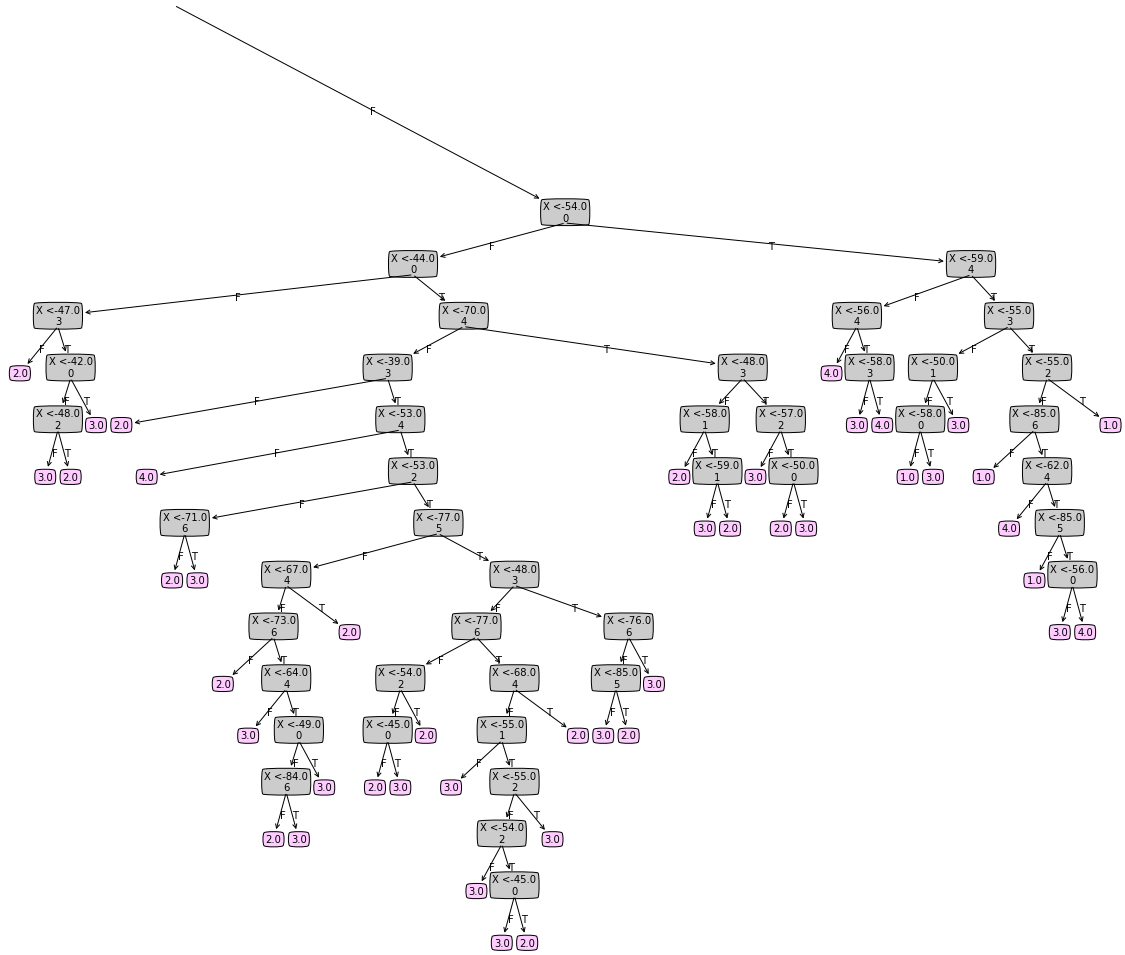

Learning Time: 2.311117649078369


In [46]:
#===========================================#
#tree visualisation  
#===========================================#
st=time.time()
tree_root, depth = tree_learning(clean_data, 0)
#n_tree_root, n_depth = tree_learning(noisy_data, 0)
et = time.time()
display_tree(tree_root) # visualisation of tree
#display_tree(n_tree_root)
print("Learning Time:" , et-st)


In [47]:
#==========================================#
#Cross validation without prune - clean data
#==========================================#

#-----------------------------------------#
print("""#==========================================#
Cross validation without prune - clean data
#==========================================#""")
st=time.time()
matrix = cross_validation(clean_data)
print("Confusion Matrix:")
print(matrix) # prints confusion matrix
acc = accuracy(matrix)
pres = precision(matrix)
rec = recall(matrix)
print("accuracy: ", acc) # accuracy 
print("\nThe precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]\n")
print("precision: ", pres) # precision per class
print("recall: ", rec) # recall per class
fmeasure = f1(rec, pres)
print("fmeasure: ", fmeasure ) # f1 per class
et=time.time()
print('Runtime: ', et-st)
#-----------------------------------------#

#==========================================#
Cross validation without prune - clean data
#==========================================#
Confusion Matrix:
[[49.6  0.   0.1  0.3]
 [ 0.  48.   2.   0. ]
 [ 0.2  1.4 48.3  0.1]
 [ 0.5  0.   0.2 49.3]]
accuracy:  0.976

The precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]

precision:  [0.9860835  0.97165992 0.95454545 0.99195171]
recall:  [0.992 0.96  0.966 0.986]
fmeasure:  [0.9890329  0.96579477 0.96023857 0.9889669 ]
Runtime:  19.10942316055298


In [48]:
#==========================================#
#Cross validation without prune - noisy data
#==========================================#

#-----------------------------------------#
print("""#==========================================#
Cross validation without prune - noisy data
#==========================================#""")
st=time.time()
matrix = cross_validation(noisy_data)
print("Confusion Matrix:")
print(matrix)
acc = accuracy(matrix)
pres = precision(matrix)
rec = recall(matrix)
print("accuracy: ", acc) # accuracy 
print("\nThe precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]\n")
print("precision: ", pres) # precision per class
print("recall: ", rec) # recall per class
fmeasure = f1(rec, pres)
print("fmeasure: ", fmeasure ) # f1 per class
et=time.time()
print('Runtime: ', et-st)
#-----------------------------------------#

#==========================================#
Cross validation without prune - noisy data
#==========================================#
Confusion Matrix:
[[37.   4.4  3.2  4.4]
 [ 3.2 40.9  3.2  2.4]
 [ 3.6  3.2 40.8  3.9]
 [ 3.6  2.1  3.3 40.8]]
accuracy:  0.7975

The precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]

precision:  [0.78059072 0.8083004  0.80792079 0.79223301]
recall:  [0.75510204 0.82293763 0.79223301 0.81927711]
fmeasure:  [0.76763485 0.81555334 0.8        0.80552813]
Runtime:  32.88418102264404


In [49]:
#==========================================#
#Cross validation with prune - clean data
#==========================================#

#-----------------------------------------#
print("""#==========================================#
Cross validation with prune - clean data
#==========================================#""")
st=time.time()
pre_prune_matrix, post_prune_matrix = cross_validation_prune(clean_data)
acc_pre_prune, acc_post_prune = accuracy(pre_prune_matrix), accuracy(post_prune_matrix)
pres_pre_prune, pres_post_prune = precision(pre_prune_matrix), precision(post_prune_matrix)
rec_pre_prune, rec_post_prune = recall(pre_prune_matrix), recall(pre_prune_matrix)
f1_pre_prune, f1_post_prune = f1(rec_pre_prune, pres_pre_prune), f1(rec_post_prune, pres_post_prune)
et=time.time()

print("accuracy pre-prune : ", acc_pre_prune) # accuracy pre-prune
print("accuracy post-prune : ", acc_post_prune) # accuracy post-prune

print("\nThe precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]\n")

print("precision pre-prune: ", pres_pre_prune) # precision per class pre-prune
print("precision post-prune: ", pres_post_prune) # precision per class post-prune

print("recall pre-prune: ", rec_pre_prune) # recall per class pre-prune
print("recall post-prune: ", rec_post_prune) # recall per class post-prune

print("fmeasure pre-prune: ", f1_pre_prune ) # f1 per class
print("fmeasure post-prune: ",  f1_post_prune)

print('Runtime: ', et-st)
#-----------------------------------------#

#==========================================#
Cross validation with prune - clean data
#==========================================#
accuracy pre-prune :  0.9710000000000001
accuracy post-prune :  0.9690000000000001

The precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]

precision pre-prune:  [0.98412698 0.96537678 0.94280079 0.99196787]
precision post-prune:  [0.98221344 0.95591182 0.94578313 0.99195171]
recall pre-prune:  [0.992 0.948 0.956 0.988]
recall post-prune:  [0.992 0.948 0.956 0.988]
fmeasure pre-prune:  [0.98804781 0.95660949 0.94935452 0.98997996]
fmeasure post-prune:  [0.98708246 0.95193947 0.95086412 0.98997191]
Runtime:  16.90155792236328


In [50]:
#==========================================#
#Cross validation with prune - noisy data
#==========================================#

#-----------------------------------------#
print("""#==========================================#
Cross validation with prune - noisy data
#==========================================#""")
st=time.time()
pre_prune_matrix, post_prune_matrix = cross_validation_prune(noisy_data)
acc_pre_prune, acc_post_prune = accuracy(pre_prune_matrix), accuracy(post_prune_matrix)
pres_pre_prune, pres_post_prune = precision(pre_prune_matrix), precision(post_prune_matrix)
rec_pre_prune, rec_post_prune = recall(pre_prune_matrix), recall(pre_prune_matrix)
f1_pre_prune, f1_post_prune = f1(rec_pre_prune, pres_pre_prune), f1(rec_post_prune, pres_post_prune)
et=time.time()

print("accuracy pre-prune : ", acc_pre_prune) # accuracy pre-prune
print("accuracy post-prune : ", post_prune_matrix) # accuracy post-prune

print("\nThe precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]\n")

print("precision pre-prune: ", pres_pre_prune) # precision per class pre-prune
print("precision post-prune: ", pres_post_prune) # precision per class post-prune

print("recall pre-prune: ", rec_pre_prune) # recall per class pre-prune
print("recall post-prune: ", rec_post_prune) # recall per class post-prune

print("fmeasure pre-prune: ", f1_pre_prune ) # f1 per class pre-prune
print("fmeasure post-prune: ",  f1_post_prune) # f1 per class post-prune

print('Runtime: ', et-st)
#-----------------------------------------#

#==========================================#
Cross validation with prune - noisy data
#==========================================#
accuracy pre-prune :  0.804
accuracy post-prune :  [[42.4  1.8  2.3  2.5]
 [ 2.6 41.4  3.9  1.8]
 [ 2.1  3.7 43.1  2.6]
 [ 3.1  2.3  2.5 41.9]]

The precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]

precision pre-prune:  [0.80785124 0.79587629 0.79626168 0.81653226]
precision post-prune:  [0.84462151 0.84146341 0.83204633 0.85860656]
recall pre-prune:  [0.79795918 0.77665996 0.82718447 0.81325301]
recall post-prune:  [0.79795918 0.77665996 0.82718447 0.81325301]
fmeasure pre-prune:  [0.80287474 0.78615071 0.81142857 0.81488934]
fmeasure post-prune:  [0.82062756 0.80776405 0.82960828 0.83531462]
Runtime:  34.34703731536865


In [51]:
#===============================================#
#Nested Cross validation with prune - clean data
#===============================================#

#-----------------------------------------#
print("""#===============================================#
Nested Cross validation with prune - clean data
#===============================================#""")
st=time.time()
pre_prune_matrix, post_prune_matrix = nested_cross_validation_prune(clean_data)
acc_pre_prune, acc_post_prune = accuracy(pre_prune_matrix), accuracy(post_prune_matrix)
pres_pre_prune, pres_post_prune = precision(pre_prune_matrix), precision(post_prune_matrix)
rec_pre_prune, rec_post_prune = recall(pre_prune_matrix), recall(pre_prune_matrix)
f1_pre_prune, f1_post_prune = f1(rec_pre_prune, pres_pre_prune), f1(rec_post_prune, pres_post_prune)
et=time.time()

print("accuracy pre-prune : ", acc_pre_prune) # accuracy pre-prune
print("accuracy post-prune : ", acc_post_prune) # accuracy post-prune

print("\nThe precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]\n")

print("precision pre-prune: ", pres_pre_prune) # precision per class pre-prune
print("precision post-prune: ", pres_post_prune) # precision per class post-prune

print("recall pre-prune: ", rec_pre_prune) # recall per class pre-prune
print("recall post-prune: ", rec_post_prune) # recall per class post-prune

print("fmeasure pre-prune: ", f1_pre_prune ) # f1 per class
print("fmeasure post-prune: ",  f1_post_prune)

print('Runtime: ', et-st)
#-----------------------------------------#

#===============================================#
Nested Cross validation with prune - clean data
#===============================================#
accuracy pre-prune :  0.9697777777777778
accuracy post-prune :  0.9702777777777777

The precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]

precision pre-prune:  [0.98559078 0.95997332 0.94795374 0.9855427 ]
precision post-prune:  [0.9832636  0.96055271 0.94749722 0.98972526]
recall pre-prune:  [0.988      0.95933333 0.94711111 0.98466667]
recall post-prune:  [0.988      0.95933333 0.94711111 0.98466667]
fmeasure pre-prune:  [0.98679392 0.95965322 0.94753224 0.98510449]
fmeasure post-prune:  [0.98562611 0.95994263 0.94730413 0.98718948]
Runtime:  130.6583547592163


In [52]:
#===============================================#
#Nested Cross validation with prune - noisy data
#===============================================#

#-----------------------------------------#
print("""#===============================================#
#Nested Cross validation with prune - noisy data
#===============================================#""")
st=time.time()
pre_prune_matrix, post_prune_matrix = nested_cross_validation_prune(noisy_data)
acc_pre_prune, acc_post_prune = accuracy(pre_prune_matrix), accuracy(post_prune_matrix)
pres_pre_prune, pres_post_prune = precision(pre_prune_matrix), precision(post_prune_matrix)
rec_pre_prune, rec_post_prune = recall(pre_prune_matrix), recall(pre_prune_matrix)
f1_pre_prune, f1_post_prune = f1(rec_pre_prune, pres_pre_prune), f1(rec_post_prune, pres_post_prune)
et=time.time()

print("accuracy pre-prune : ", acc_pre_prune) # accuracy pre-prune
print("accuracy post-prune : ", acc_post_prune) # accuracy post-prune

print("\nThe precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]\n")

print("precision pre-prune: ", pres_pre_prune) # precision per class pre-prune
print("precision post-prune: ", pres_post_prune) # precision per class post-prune

print("recall pre-prune: ", rec_pre_prune) # recall per class pre-prune
print("recall post-prune: ", rec_post_prune) # recall per class post-prune

print("fmeasure pre-prune: ", f1_pre_prune ) # f1 per class pre-prune
print("fmeasure post-prune: ",  f1_post_prune) # f1 per class post-prune

print('Runtime: ', et-st)
#-----------------------------------------#

#===============================================#
#Nested Cross validation with prune - noisy data
#===============================================#
accuracy pre-prune :  0.7938333333333333
accuracy post-prune :  0.8518333333333333

The precision, recall and f1 metrics are returned as an array where each entry is the value of the metric for the room in the form [r1 r2 r3 r4]

precision pre-prune:  [0.79516392 0.79790553 0.77949468 0.80393487]
precision post-prune:  [0.84285397 0.86023933 0.84338647 0.86139955]
recall pre-prune:  [0.7755102  0.80058127 0.80539374 0.79317269]
recall post-prune:  [0.7755102  0.80058127 0.80539374 0.79317269]
fmeasure pre-prune:  [0.7852141  0.79924116 0.7922326  0.79851752]
fmeasure post-prune:  [0.80778092 0.82933881 0.82395238 0.82587944]
Runtime:  266.0536890029907
